In [3]:
import os
import re
import cv2
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from wordcloud import WordCloud, ImageColorGenerator
from sklearn.model_selection import train_test_split

In [4]:
with open("NLMCXR_reports/ecgen-radiology/1.xml", "r") as f:
    xml = f.read()
print(xml)

<?xml version="1.0" encoding="utf-8"?>
<eCitation>
   <meta type="rr"/>
   <uId id="CXR1"/>
   <pmcId id="1"/>
   <docSource>CXR</docSource>
   <IUXRId id="1"/>
   <licenseType>open-access</licenseType>
   <licenseURL>http://creativecommons.org/licenses/by-nc-nd/4.0/</licenseURL>
   <ccLicense>byncnd</ccLicense>
   <articleURL/>
   <articleDate>2013-08-01</articleDate>
   <articleType>XR</articleType>
   <publisher>Indiana University</publisher>
   <title>Indiana University Chest X-ray Collection</title>
   <note>The data are drawn from multiple hospital systems.</note>
   <specialty>pulmonary diseases</specialty>
   <subset>CXR</subset>
   <MedlineCitation Owner="Indiana University" Status="supplied by publisher">
   
      <Article PubModel="Electronic">
      
         <Journal>
         
            <JournalIssue>
            
               <PubDate>
               
                  <Year>2013</Year>
               
                  <Month>08</Month>
               
            

The important fields in the XML file are:
1. pmcid : Patient id
2. image id
3. Comparision
4. indiation findings
5. impressions

In [5]:
print('Total images present in the data : ', len(os.listdir('NLMCXR_png/')))
print('Total reports present in the data : ', len(os.listdir('NLMCXR_reports/ecgen-radiology')))

Total images present in the data :  7471
Total reports present in the data :  3955


It appears that there might be more than 2 images associated per report. Let's find the distribution of images.

In [6]:
# Directory path for XML files
xml_dir = 'NLMCXR_reports/ecgen-radiology'

# List to store the count of images
img_count = []

# Iterate over XML files in the directory
for file in os.listdir(xml_dir):
    xml_file = os.path.join(xml_dir, file)
    
    # Read the XML data
    with open(xml_file, 'r') as f:
        data = f.read()
    
    # Extract the image names using regex
    regex = r"parentImage id.*"
    image_names = re.findall(regex, data)
    
    # Get the count of images
    temp = len(image_names)
    img_count.append(temp)

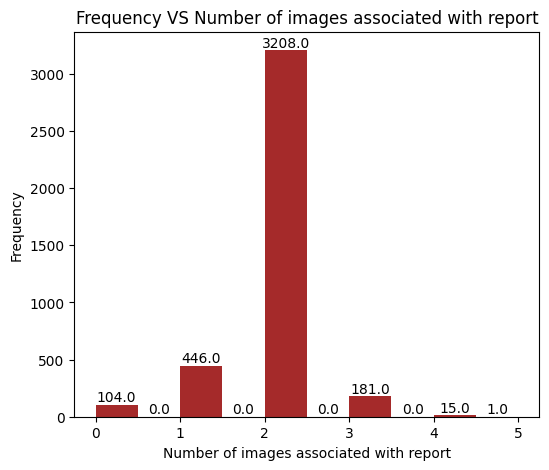

In [7]:
# Plotting the histogram
plt.figure(figsize=(6, 5))
ax = pd.Series(img_count).plot(kind='hist', color='brown')
ax.set_xlabel('Number of images associated with report')
ax.set_title("Frequency VS Number of images associated with report")

# Add count labels on top of each bar
for rect in ax.patches:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height, height, ha='center', va='bottom')

plt.show()

It appears from the data that there 0 to 5 images per report. There are 3208 reports with 2 images each. That means that these reports have a lateral and frontal image each. 

Next step os to read the xml files and convert them to a dataframe.

In [8]:
columns = ["image_id", "image_caption", "comparison", "indication", "findings", "impression"]

scraped_data = pd.DataFrame(columns=columns)

for file in tqdm(os.listdir("NLMCXR_reports/ecgen-radiology/")):
    k = "NLMCXR_reports/ecgen-radiology/"
    path = k + file
    mytree = ET.parse(path)

    comparision = mytree.find(".//AbstractText[@Label='COMPARISON']").text
    indication = mytree.find(".//AbstractText[@Label='INDICATION']").text
    findings = mytree.find(".//AbstractText[@Label='FINDINGS']").text
    impression = mytree.find(".//AbstractText[@Label='IMPRESSION']").text

    mytree = ET.parse(path)
    for x in mytree.findall("parentImage"):
        image_id = x.attrib['id'] + ".png"
        filename = 'NLMCXR_png/' + image_id
        image = cv2.imread(filename)

        caption = '' if x.find('caption').text is None else x.find('caption').text

        # Append directly without using the 'df' variable
        scraped_data = pd.concat([scraped_data, pd.DataFrame([[image_id, caption, comparision, indication, findings, impression ]], columns=columns)], ignore_index=True)


100%|██████████| 3955/3955 [00:24<00:00, 161.35it/s]


In [9]:
scraped_data.head()

,image_id,image_caption,comparison,indication,findings,impression
0,CXR1_1_IM-0001-3001.png,Xray Chest PA and Lateral,None.,Positive TB test,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
1,CXR1_1_IM-0001-4001.png,Xray Chest PA and Lateral,None.,Positive TB test,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
2,CXR10_IM-0002-1001.png,PA and lateral chest x-XXXX XXXX.,Chest radiographs XXXX.,"XXXX-year-old male, chest pain.",The cardiomediastinal silhouette is within nor...,No acute cardiopulmonary process.
3,CXR10_IM-0002-2001.png,PA and lateral chest x-XXXX XXXX.,Chest radiographs XXXX.,"XXXX-year-old male, chest pain.",The cardiomediastinal silhouette is within nor...,No acute cardiopulmonary process.
4,CXR100_IM-0002-1001.png,"CHEST 2V FRONTAL/LATERAL XXXX, XXXX XXXX PM",None.,None,Both lungs are clear and expanded. Heart and m...,No active disease.


In [10]:
scraped_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7470 entries, 0 to 7469
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image_id       7470 non-null   object
 1   image_caption  7470 non-null   object
 2   comparison     6313 non-null   object
 3   indication     7311 non-null   object
 4   findings       6473 non-null   object
 5   impression     7418 non-null   object
dtypes: object(6)
memory usage: 350.3+ KB


In [11]:
def decontracted(phrase: str) -> str:
    """
    Performs text decontraction of words like won't to will not.

    Args:
        phrase (str): The input phrase to decontract.

    Returns:
        str: The decontracted phrase.
    """
    # Dictionary to store the contraction mappings
    contractions = {
        "won't": "will not",
        "can't": "can not",
        "n't": " not",
        "'re": " are",
        "'s": " is",
        "'d": " would",
        "'ll": " will",
        "'ve": " have",
        "'m": " am"
    }

    # Iterate over the contraction mappings and replace them in the phrase
    for contraction, expansion in contractions.items():
        phrase = re.sub(contraction, expansion, phrase)

    return phrase

In [12]:
def preprocess_text(data: pd.Series):
    """
    Preprocesses the text data by extracting information from XML files and applying various text preprocessing techniques.

    Args:
      data (pd.Series): The input data containing sentences to be preprocessed.

    Returns:
      List[str]: The preprocessed sentences.
    """

    preprocessed = []

    for sentence in tqdm(data.values):
        
        # Remove numeric values followed by a dot
        sentence = re.sub(r"\d.", "", sentence)

        # Remove consecutive 'X' characters
        sentence = re.sub(r"X+", "", sentence)

        # Remove special characters except for full stop
        sentence = re.sub(r"[^.a-zA-Z]", " ", sentence)

        # Remove URLs
        sentence = re.sub(r"http\S+", "", sentence)

        # Remove other special characters
        sentence = re.sub(
            r"[-()\"#/@;:<>{}`+=~|.!?$%^&*'/+\[\]_]+", "", sentence)

        # Replace '&' with 'and'
        sentence = re.sub('&', 'and', sentence)

        # Replace '@' with 'at'
        sentence = re.sub('@', 'at', sentence)

        # Replace numeric digits with their word representation
        sentence = re.sub(
            r'\b(\d+)\b', lambda match: num2words(int(match.group(0))), sentence)

        # Remove 'year old' and 'yearold' occurrences
        sentence = re.sub('year old', "", sentence)
        sentence = re.sub('yearold', "", sentence)

        # Perform decontraction
        sentence = decontracted(sentence)

        # Strip leading and trailing spaces, convert to lowercase
        sentence = sentence.strip().lower()

        # Remove extra spaces
        sentence = " ".join(sentence.split())

        # If the resulting sentence is empty, replace with NaN
        if sentence == "":
            sentence = np.nan

        preprocessed.append(sentence)

    return preprocessed

In [13]:
# Check for null values in text columns
NaN = scraped_data.isnull().sum()
print("Total NaN Values in image_caption column:", NaN['image_caption'])
print("Total NaN Values in comparison column:", NaN['comparison'])
print("Total NaN Values in indication column:", NaN['indication'])
print("Total NaN Values in findings column:", NaN['findings'])
print("Total NaN Values in impression column:", NaN['impression'])

# Replace null values with proper substitutes
scraped_data['image_caption'].fillna('Unknown', inplace=True)
scraped_data['comparison'].fillna('No Comparison', inplace=True)
scraped_data['indication'].fillna('No Indication', inplace=True)
scraped_data['findings'].fillna('No Findings', inplace=True)
scraped_data['impression'].fillna('No Impression', inplace=True)

# Check for null values in text columns after replacement
NaN = scraped_data.isnull().sum()
print("Total NaN Values in image_caption column after replacement:", NaN['image_caption'])
print("Total NaN Values in comparison column after replacement:", NaN['comparison'])
print("Total NaN Values in indication column after replacement:", NaN['indication'])
print("Total NaN Values in findings column after replacement:", NaN['findings'])
print("Total NaN Values in impression column after replacement:", NaN['impression'])

Total NaN Values in image_caption column: 0
Total NaN Values in comparison column: 1157
Total NaN Values in indication column: 159
Total NaN Values in findings column: 997
Total NaN Values in impression column: 52
Total NaN Values in image_caption column after replacement: 0
Total NaN Values in comparison column after replacement: 0
Total NaN Values in indication column after replacement: 0
Total NaN Values in findings column after replacement: 0
Total NaN Values in impression column after replacement: 0


In [14]:
# Preprocessing of text features
scraped_data['image_caption'] = preprocess_text(scraped_data['image_caption'])
scraped_data['comparison'] = preprocess_text(scraped_data['comparison'])
scraped_data['indication'] = preprocess_text(scraped_data['indication'])
scraped_data['findings'] = preprocess_text(scraped_data['findings'])
scraped_data['impression'] = preprocess_text(scraped_data['impression'])

100%|██████████| 7470/7470 [00:00<00:00, 61720.07it/s]


In [15]:
scraped_data.replace("", float("NaN"), inplace=True)
scraped_data.dropna(subset = ["image_id"], inplace=True)


In [16]:
scraped_data.head()

,image_id,image_caption,comparison,indication,findings,impression
0,CXR1_1_IM-0001-3001.png,ray chest pa and lateral,none,positive tb test,the cardiac silhouette and mediastinum size ar...,normal chest x
1,CXR1_1_IM-0001-4001.png,ray chest pa and lateral,none,positive tb test,the cardiac silhouette and mediastinum size ar...,normal chest x
2,CXR10_IM-0002-1001.png,pa and lateral chest x,chest radiographs,male chest pain,the cardiomediastinal silhouette is within nor...,no acute cardiopulmonary process
3,CXR10_IM-0002-2001.png,pa and lateral chest x,chest radiographs,male chest pain,the cardiomediastinal silhouette is within nor...,no acute cardiopulmonary process
4,CXR100_IM-0002-1001.png,chest frontal lateral pm,none,no indication,both lungs are clear and expanded heart and me...,no active disease


In [17]:
scraped_data.shape

(7470, 6)

In [18]:
# Create a copy of the scraped_data dataframe
concatenated_data = scraped_data.copy()

# Group the dataframe by image ID without the last 9 numbers
grouped_data = concatenated_data.groupby(concatenated_data['image_id'].str[:-9])

# Concatenate the image IDs within each group
concatenated_data['image_id'] = grouped_data['image_id'].transform(lambda x: ', '.join(x))

# Drop duplicate rows
concatenated_data.drop_duplicates(inplace=True)

# Reset the index
concatenated_data.reset_index(drop=True, inplace=True)


In [19]:
scraped_data.to_csv('scraped_data.csv', index=False)

In [20]:
concatenated_data.shape

(3914, 6)

In [21]:
def preprocess_data(concatenated_data):
    """
    Preprocesses the given concatenated_data DataFrame by adding new columns for image_count, indication_count,
    findings_count, and impression_count.

    Parameters:
    concatenated_data (DataFrame): The input DataFrame containing the data to be preprocessed.

    Returns:
    DataFrame: The preprocessed DataFrame with the added columns.
    """
    concatenated_data['image_count'] = concatenated_data['image_id'].astype(str).str.split(',').apply(len)
    concatenated_data['indication_count'] = concatenated_data['indication'].astype(str).str.split().apply(lambda x: 0 if x==None else len(x))
    concatenated_data['findings_count'] = concatenated_data['findings'].astype(str).str.split().apply(lambda x: 0 if x==None else len(x))
    concatenated_data['impression_count'] = concatenated_data['impression'].astype(str).str.split().apply(lambda x: 0 if x==None else len(x))
    return concatenated_data

In [22]:

preprocessed_data = preprocess_data(concatenated_data)
preprocessed_data.head()

,image_id,image_caption,comparison,indication,findings,impression,image_count,indication_count,findings_count,impression_count
0,"CXR1_1_IM-0001-3001.png, CXR1_1_IM-0001-4001.png",ray chest pa and lateral,none,positive tb test,the cardiac silhouette and mediastinum size ar...,normal chest x,2,3,33,3
1,"CXR10_IM-0002-1001.png, CXR10_IM-0002-2001.png",pa and lateral chest x,chest radiographs,male chest pain,the cardiomediastinal silhouette is within nor...,no acute cardiopulmonary process,2,3,38,4
2,"CXR100_IM-0002-1001.png, CXR100_IM-0002-2001.png",chest frontal lateral pm,none,no indication,both lungs are clear and expanded heart and me...,no active disease,2,2,10,3
3,"CXR1000_IM-0003-1001.png, CXR1000_IM-0003-2001...",pa and lateral chest x,pa and lateral chest radiographs,male,there is increased opacity within the right up...,increased opacity in the right upper lobe with...,3,1,52,36
4,"CXR1001_IM-0004-1001.png, CXR1001_IM-0004-1002...",chest frontal lateral pm,none,dyspnea subjective fevers arthritis immigrant ...,interstitial markings are diffusely prominent ...,diffuse fibrosis no visible focal acute disease,2,7,14,7


In [23]:
image_count_sum = concatenated_data['image_count'].sum()
print("Sum of image_count column:", image_count_sum)

Sum of image_count column: 7470


In [24]:
concatenated_data.to_csv('concatenated_data.csv', index=False)